# Can You Tell the Difference? - AI vs. Human-Generated Image Classification

In the fast-evolving world of AI, distinguishing between authentic human-created images and AI-generated ones is becoming a critical challenge. This competition, **Can You Tell the Difference?**, offers a real-world opportunity to develop machine learning models to identify AI-generated content from genuine human-created visuals. With the rise of deepfakes and generative art, this challenge has immense implications for media authenticity, security, and creativity.

### The Impact of Deepfakes
Deepfakes have made headlines in recent years for their ability to manipulate video and images, creating realistic but entirely fabricated content. As the technology behind deepfakes improves, it’s becoming increasingly difficult to distinguish between what’s real and what’s generated. This competition challenges us to tackle this issue head-on, creating models capable of distinguishing these subtle differences.

![Deepfake Example](https://i.pcmag.com/imagery/articles/01lTyBxcS2L9vruDcS4D2Ho-1.fit_lim.size_1600x900.v1692729678.png)


### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score ,roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torchvision.models as models

from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from torch.amp import GradScaler, autocast

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available, using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU.")


CUDA is available, using GPU.


### Setting the Seed for Reproducibility

This function ensures that random operations across different libraries and hardware (CPU/GPU) are reproducible.


In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set fixed seed
set_seed(42)

### Loading the Dataset

In [4]:
# Load the dataset
base_dir = '/kaggle/input/ai-vs-human-generated-dataset'
train_df = pd.read_csv("/kaggle/input/detect-ai-vs-human-generated-images/train.csv")
test_df = pd.read_csv("/kaggle/input/detect-ai-vs-human-generated-images/test.csv")

# Display basic info
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
train_df.head()

Train dataset shape: (79950, 3)
Test dataset shape: (5540, 1)


,Unnamed: 0,file_name,label
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [5]:
test_df.head()

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [6]:
train_df = train_df.drop(columns=['Unnamed: 0'])

### Convert File Paths to Absolute Paths

### Modifying File Paths

 - Updates the `id` column in the test dataset to include the full file path by joining the `base_dir` with the relative file path for each image.
 - Updates the `file_name` column in the training dataset to include the full file path by joining the `base_dir` with the relative file path for each image.

### Displaying Dataset Sizes
This code ensures the file paths for images are complete and also prints the size of the train and test datasets.


In [7]:
# Adding the full path to the file_name instead of just "trainORtest_data/xxx.jpg"
test_df['id'] = test_df['id'].apply(lambda x: os.path.join(base_dir, x))
train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(base_dir, x))


print(f"Train Data: {len(train_df)}")
print(f"Test Data: {len(test_df)}")

Train Data: 79950
Test Data: 5540


### EDA

### Checking for Missing Values and Duplicates

This helps ensure the datasets are clean before further processing.

In [8]:
# Check for missing values
print("Missing values in Train Dataset:\n", train_df.isnull().sum())
print("Missing values in Test Dataset:\n", test_df.isnull().sum())

# Check for duplicates
print("Duplicate entries in Train Dataset:", train_df.duplicated().sum())


Missing values in Train Dataset:
 file_name    0
label        0
dtype: int64
Missing values in Test Dataset:
 id    0
dtype: int64
Duplicate entries in Train Dataset: 0


## Results of Missing Values and Duplicates Check

This confirms that both datasets are free of missing values and duplicates.

---------------------

### Countplot of AI vs. Human-Generated Images

The following plot visualizes the distribution of the target variable (`label`) in the **train dataset**. It shows the number of **Human-Created** vs **AI-Generated** images, based on the `label` column.

This is a **distribution plot** of the target variable (`label`).


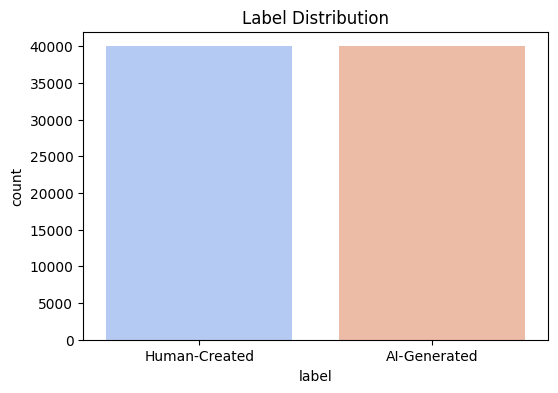

In [9]:
# Countplot of AI vs. Human-generated images
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=train_df, palette="coolwarm")
plt.title("Label Distribution")
plt.xticks([0, 1], ["Human-Created", "AI-Generated"])
plt.show()


## Distribution Analysis

The countplot reveals that there is **equal distribution** between the **Human-Created** and **AI-Generated** images in the training dataset. Both classes have similar numbers of samples, which is beneficial for training balanced models.
********

### Displaying Example Images

visual inspection of image samples in the dataset based on their respective labels.


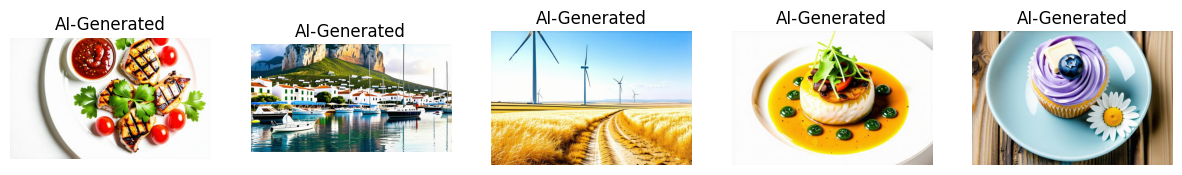

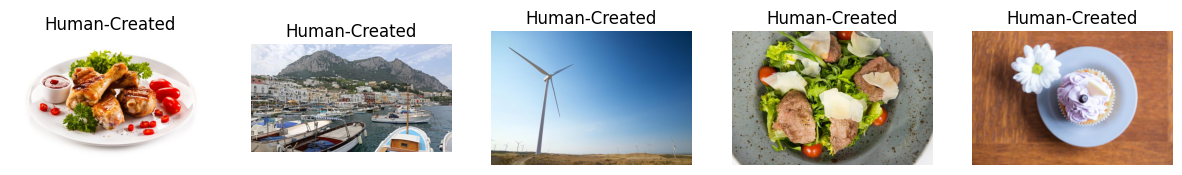

In [10]:
# Function to display images
def show_images(df, label, num_images=5):
    sample_images = df[df["label"] == label].sample(num_images, random_state=42)["file_name"].values

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("AI-Generated" if label == 1 else "Human-Created")
        
    plt.show()

# Show AI-Generated Images
show_images(train_df, label=1)

# Show Human-Created Images
show_images(train_df, label=0)

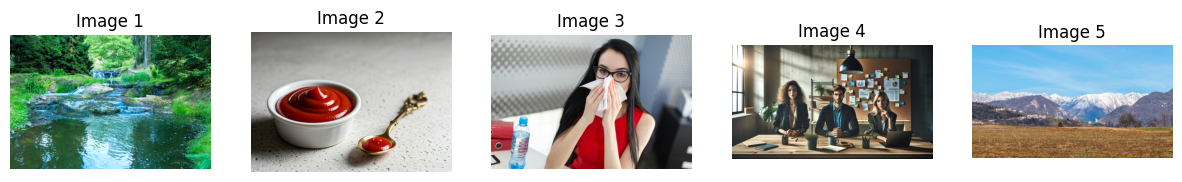

In [11]:
# Function to display random test images
def show_test_images(df, num_images=5):
    sample_images = df.sample(num_images, random_state=42)["id"].values  

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image {i+1}")  
    
    plt.show()

# Show random test images
show_test_images(test_df, num_images=5)


### Getting Dimensions for Train and Test Datasets

- The function is applied to the **train** and **test** datasets separately using `train_df["file_name"]` and `test_df["id"]` to get the image dimensions.

### Plotting Image Dimension Distributions

This visualization helps compare the distribution of image sizes across the train and test datasets.


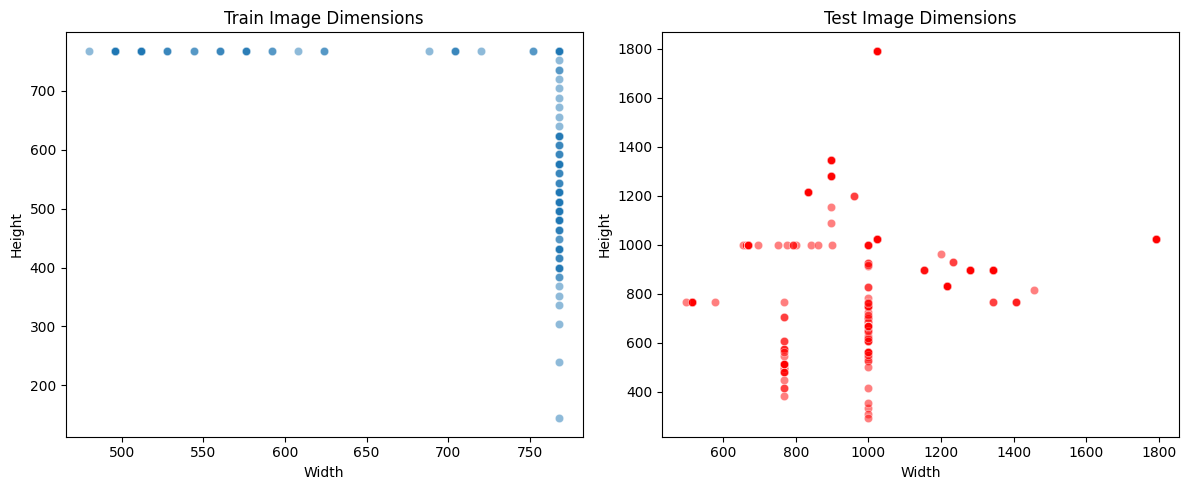

In [12]:
# Function to get image dimensions
def get_image_dimensions(image_paths, sample_size=500):
    image_sizes = []
    
    for img_path in image_paths.sample(sample_size, random_state=42):  # Randomly sampling
        img = cv2.imread(img_path)
        if img is not None:
            h, w, _ = img.shape
            image_sizes.append((w, h))
    
    return pd.DataFrame(image_sizes, columns=["Width", "Height"])

# Get dimensions for train and test separately
train_size_df = get_image_dimensions(train_df["file_name"])
test_size_df = get_image_dimensions(test_df["id"])

# Plot Train vs. Test Image Dimension Distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=train_size_df["Width"], y=train_size_df["Height"], alpha=0.5, ax=axes[0])
axes[0].set_title("Train Image Dimensions")
axes[0].set_xlabel("Width")
axes[0].set_ylabel("Height")

sns.scatterplot(x=test_size_df["Width"], y=test_size_df["Height"], alpha=0.5, ax=axes[1], color='red')
axes[1].set_title("Test Image Dimensions")
axes[1].set_xlabel("Width")
axes[1].set_ylabel("Height")

plt.tight_layout()
plt.show()


### Insights from Image Dimension Distribution Plots

- **Train Image Dimensions**: 
  - The scatterplot for the **train dataset** shows that most images have a consistent height around **750 pixels**, with varying widths. There is a cluster of data points along the upper edge of the plot, indicating uniformity in the height dimensions for the majority of images.
  
- **Test Image Dimensions**: 
  - The **test dataset** shows a more varied distribution of image dimensions, with a wider range of heights and widths. There are several images with much larger dimensions (around **1000 to 1800 pixels** in height), indicating that the test dataset may have images of varying resolutions.

These insights help understand the variability in image dimensions across the datasets, which could influence model performance and pre-processing steps.


### Dimensions of human cretaed and ai generated images


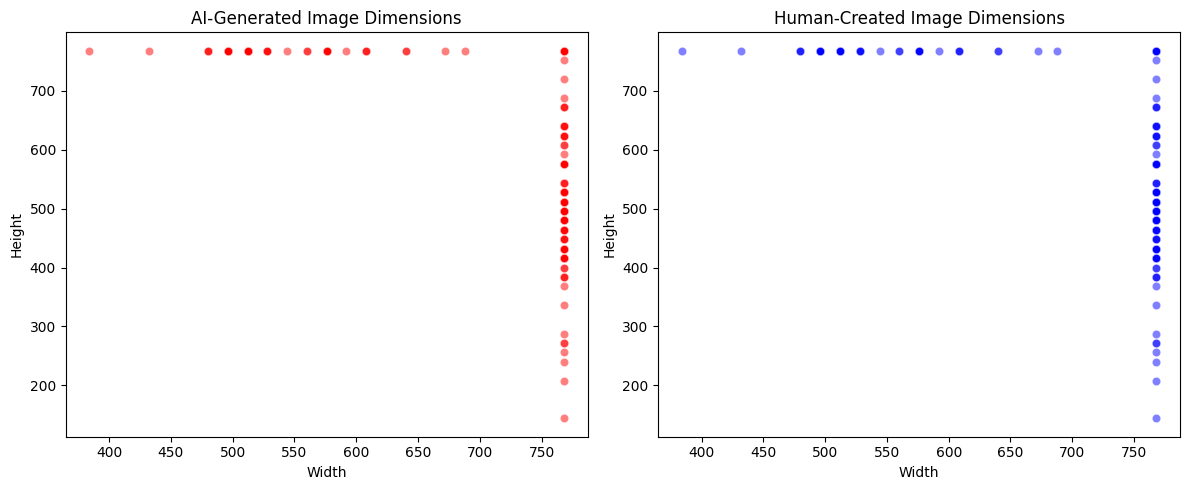

In [13]:
# Function to get image dimensions
def get_image_dimensions(image_paths, sample_size=500):
    image_sizes = []
    
    for img_path in image_paths.sample(sample_size, random_state=42):  # Randomly sampling
        img = cv2.imread(img_path)
        if img is not None:
            h, w, _ = img.shape
            image_sizes.append((w, h))
    
    return pd.DataFrame(image_sizes, columns=["Width", "Height"])

# Separate AI-generated and Human-created images
ai_images = train_df[train_df["label"] == 1]["file_name"]
human_images = train_df[train_df["label"] == 0]["file_name"]

# Get dimensions for both categories
ai_size_df = get_image_dimensions(ai_images)
human_size_df = get_image_dimensions(human_images)

# Plot AI vs. Human Image Dimension Distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=ai_size_df["Width"], y=ai_size_df["Height"], alpha=0.5, ax=axes[0], color='red')
axes[0].set_title("AI-Generated Image Dimensions")
axes[0].set_xlabel("Width")
axes[0].set_ylabel("Height")

sns.scatterplot(x=human_size_df["Width"], y=human_size_df["Height"], alpha=0.5, ax=axes[1], color='blue')
axes[1].set_title("Human-Created Image Dimensions")
axes[1].set_xlabel("Width")
axes[1].set_ylabel("Height")

plt.tight_layout()
plt.show()


### Insights from AI vs. Human-Created Image Dimension Distribution Plots

- **AI-Generated Image Dimensions**: 
  - The scatterplot for **AI-generated images** shows a concentration of images with consistent dimensions, with most of the images having a height around **750 pixels** and varying widths. This suggests a more uniform resolution among AI-generated images in the dataset.
  
- **Human-Created Image Dimensions**: 
  - The **human-created images** also show consistent dimensions, with most images having a height near **750 pixels**, but the distribution of widths seems slightly more spread out, indicating more variation in the width of human-created images compared to AI-generated ones.

These observations highlight that both AI-generated and human-created images tend to have a similar resolution range, with slight differences in the variation of image widths.
*********************

### Pixel Intensity Comparison between AI-Generated and Human-Created Images


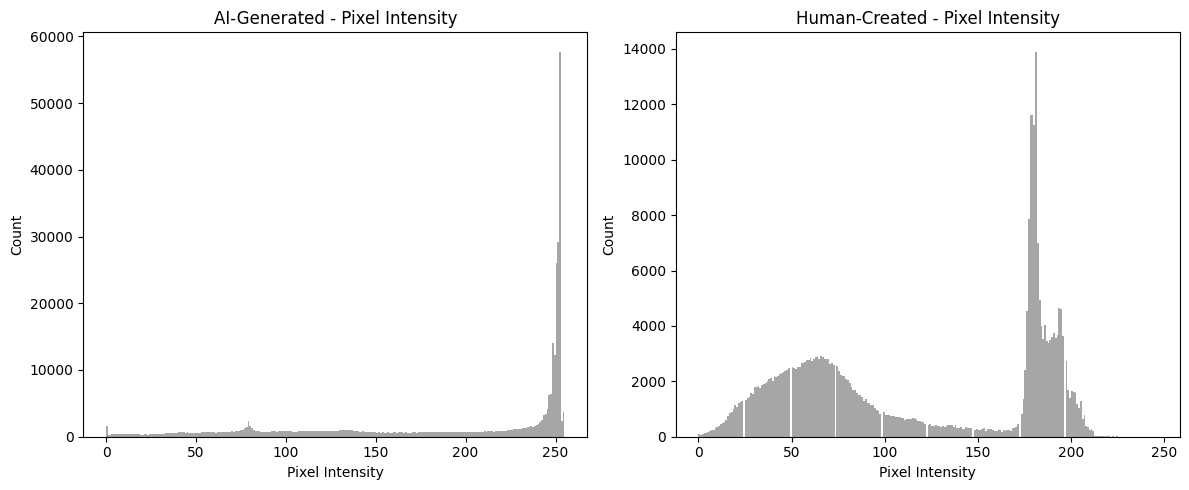

In [14]:
def plot_pixel_intensity_side_by_side(img_path1, img_path2, title1="AI-Generated", title2="Human-Created"):
    img1 = cv2.imread(img_path1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    axes[0].hist(img1.ravel(), bins=256, color="gray", alpha=0.7)
    axes[0].set_xlabel("Pixel Intensity")
    axes[0].set_ylabel("Count")
    axes[0].set_title(f"{title1} - Pixel Intensity")

    axes[1].hist(img2.ravel(), bins=256, color="gray", alpha=0.7)
    axes[1].set_xlabel("Pixel Intensity")
    axes[1].set_ylabel("Count")
    axes[1].set_title(f"{title2} - Pixel Intensity")

    plt.tight_layout()
    plt.show()

# Select random AI-generated and human-created images
sample_ai = train_df[train_df["label"] == 1]["file_name"].sample(1).values[0]
sample_human = train_df[train_df["label"] == 0]["file_name"].sample(1).values[0]

# Plot side by side
plot_pixel_intensity_side_by_side(sample_ai, sample_human)


### Insights on Pixel Intensity Distribution

- **AI-Generated Image** (left plot): The pixel intensity distribution of AI-generated images shows a sharp peak near the maximum pixel value (255), with a significant amount of pixels clustered in that region, indicating high contrast and possibly sharp areas in the image.
  
- **Human-Created Image** (right plot): The pixel intensity distribution of human-created images shows a more spread-out distribution with a peak in the middle range. This suggests a more balanced intensity spread, typical of natural lighting and tones in human-created images.

In summary, the AI-generated images have a concentrated pixel intensity at higher values, indicating high contrast, while the human-created images have a more even distribution of pixel intensities.

*************

### Color Distribution Comparison between AI-Generated and Human-Created Images
compares the color distribution (Red, Green, Blue channels) of AI-generated and human-created images. It does so by reading both images, splitting them into RGB channels, and plotting histograms for each channel. The histograms show the frequency of pixel values for each color in the images. The results are displayed side by side for easy comparison.


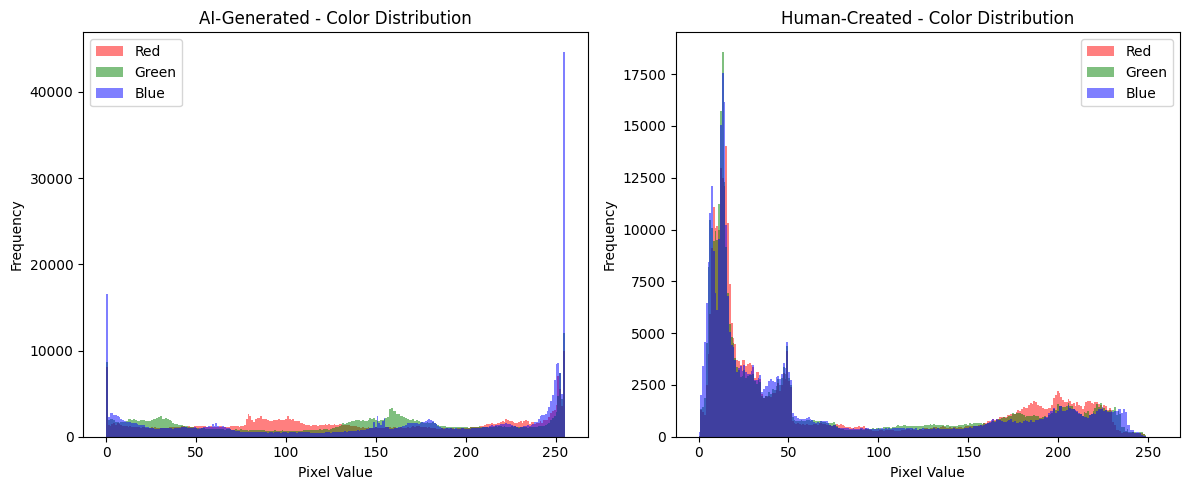

In [15]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd

def plot_color_distribution_side_by_side(img_path1, img_path2, title1="AI-Generated", title2="Human-Created"):
    img1 = cv2.imread(img_path1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    
    img2 = cv2.imread(img_path2)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Splitting into RGB channels
    r1, g1, b1 = cv2.split(img1)
    r2, g2, b2 = cv2.split(img2)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # AI-Generated Image Histogram
    axes[0].hist(r1.ravel(), bins=256, color="red", alpha=0.5, label="Red")
    axes[0].hist(g1.ravel(), bins=256, color="green", alpha=0.5, label="Green")
    axes[0].hist(b1.ravel(), bins=256, color="blue", alpha=0.5, label="Blue")
    axes[0].set_xlabel("Pixel Value")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title(f"{title1} - Color Distribution")
    axes[0].legend()

    # Human-Created Image Histogram
    axes[1].hist(r2.ravel(), bins=256, color="red", alpha=0.5, label="Red")
    axes[1].hist(g2.ravel(), bins=256, color="green", alpha=0.5, label="Green")
    axes[1].hist(b2.ravel(), bins=256, color="blue", alpha=0.5, label="Blue")
    axes[1].set_xlabel("Pixel Value")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title(f"{title2} - Color Distribution")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Select random AI-generated and human-created images
sample_ai = train_df[train_df["label"] == 1]["file_name"].sample(1).values[0]
sample_human = train_df[train_df["label"] == 0]["file_name"].sample(1).values[0]

# Plot side by side
plot_color_distribution_side_by_side(sample_ai, sample_human)


### Insights on Color Distribution in AI-Generated and Human-Created Images

- **AI-Generated Image** (left plot): The color distribution for the AI-generated image shows very sharp peaks for the Red and Blue channels near the maximum pixel value (255). The Green channel, however, has a more evenly spread distribution, suggesting that the AI-generated image might have higher saturation and contrast in the red and blue channels, possibly resulting in a more intense or artificial color appearance.

- **Human-Created Image** (right plot): In the human-created image, the color distribution is more balanced, with all three color channels (Red, Green, and Blue) showing similar spread patterns. The Green channel has a slightly higher frequency, but the overall distribution appears more natural, with less contrast between the channels.

In conclusion, AI-generated images exhibit a more pronounced intensity in the Red and Blue channels, while human-created images demonstrate a more balanced and natural distribution of colors across the RGB spectrum.
********************

### Splitting into train test

1. **Splitting the Dataset**:
   - **Test Size**: 5% of the data will be allocated to the validation set, leaving 95% in the training set.
   - **Stratification**: the data is split while maintaining the original distribution of the labels (AI-generated vs. Human-created). This ensures both training and validation sets have a balanced representation of each label.
   - **Random State**: The `random_state=42` ensures reproducibility of the split.

This split prepares the data for training and validation purposes while maintaining a balanced label distribution.


In [16]:
# ✅ Split the train_df DataFrame itself, NOT just 'file_name' and 'label' separately
train_df, val_df = train_test_split(
    train_df,  
    test_size=0.05,        
    stratify=train_df['label'],  
    random_state=42
)

# ✅ Print checks
print(f"Train Data: {len(train_df)}")
print(f"Validation Data: {len(val_df)}")
print(f"Test Data: {len(test_df)}")  # Test data remains unchanged


Train Data: 75952
Validation Data: 3998
Test Data: 5540


## Data Augmentations

- **Training Augmentation**: It introduces variability to the training data, helping the model learn more robust features.
- **Testing (No Augmentation)**: During testing, we don't apply augmentation to ensure that the evaluation is done on a consistent, unaltered version of the images.


In [17]:
# ✅ Training Transformations (with Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((232)),                
    transforms.RandomResizedCrop(224),  
    transforms.RandomHorizontalFlip(),      
    transforms.RandomRotation(10),           
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.ToTensor(),        
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])                        
    
# ✅ Testing Transformations (NO Augmentation)
test_transforms = transforms.Compose([
    transforms.Resize(232),  
    transforms.CenterCrop(224),             
    transforms.ToTensor(),                        
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])   
])


### Code Explanation for `CustomDataset` Class:

This class is a custom dataset class inheriting from PyTorch's `Dataset`, designed to handle image data and provide an interface for the model to use during training and testing.

In [18]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        self.df = pd.DataFrame(df)  # Ensure it's a DataFrame
        self.transform = transform
        self.is_test = is_test  # Test dataset flag

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["file_name"]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.is_test:
            return img  # No label for test dataset
        else:
            label = self.df.iloc[idx]["label"]
            return img, label


In [19]:
# ✅ Train & Validation Datasets
train_dataset = CustomDataset(df=train_df, transform=train_transforms)
val_dataset = CustomDataset(df=val_df, transform=test_transforms)

batch_size = 8
# ✅ DataLoaders
#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Train dataset size: 75952
Validation dataset size: 3998


### ==> Check a batch from train/val loader:

In [20]:
batch_images, batch_labels = next(iter(train_loader))
print(f"Batch shape: {batch_images.shape}, Labels shape: {batch_labels.shape}")


Batch shape: torch.Size([8, 3, 224, 224]), Labels shape: torch.Size([8])


In [21]:
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device: {device}")


CUDA Available: True
Device: cuda


## Resnet MOdel

In [22]:
#  Load Pretrained ResNet Model
#model = models.resnet18(pretrained=True)

#  Modify Final Layer for Binary Classification (AI vs. Human)
#num_features = model.fc.in_features
#model.fc = nn.Linear(num_features, 2)  

#  Move the model to the correct device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = model.to(device)

#print("Model Loaded Successfully!")
#for name, param in model.named_parameters():
    #print(f"{name} : {param.requires_grad} | {param.shape}")

## Unfreeze some layers (e.g., last 2 blocks of ResNet)
#for name, param in model.named_parameters():
   # if "layer4" in name or "layer3" in name:  # Modify based on model
   #     param.requires_grad = True  # Unfreeze
   # else:
    #    param.requires_grad = False  # Keep frozen


## ConvNext Model


In [23]:
# import torch
# import torchvision.models as models

# model = models.convnext_large(pretrained=True)

# # Freeze layers (optional)
# for param in model.parameters():
#     param.requires_grad = False

# # Modify classifier
# num_ftrs = model.classifier[2].in_features
# num_classes = 2  # Change based on competition
# model.classifier[2] = torch.nn.Linear(num_ftrs, num_classes)

# # Move model to GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # ✅ Step 1: Freeze All Layers
# for param in model.parameters():
#     param.requires_grad = False  

# # ✅ Step 2: Unfreeze Last 10 Layers (Fine-Tuning)
# for param in list(model.parameters())[-10:]:  
#     param.requires_grad = True  

# # ✅ Step 3: Modify Classifier for Binary Classification
# model.classifier = nn.Sequential(
#     nn.AdaptiveAvgPool2d((1, 1)),  
#     nn.Flatten(),                  
#     nn.Linear(1536, 512),  
#     nn.ReLU(),                    
#     nn.Dropout(0.4),              
#     nn.Linear(512, 1)
# )

# ✅ Move Model to GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# print("✅ ConvNext Model Ready for Binary Classification Training!")


✅ Pooling bhi ho rahi hai (Feature Compression)

✅ Binary Classification ke liye correct output format hai

✅ Dropout aur ReLU extra learning power dete hain

# VitConX 

In [24]:
import torch
import torch.nn as nn
from timm import create_model

class ViTConXWithAvgPooling(nn.Module):
    def __init__(self, num_classes=1):
        super(ViTConXWithAvgPooling, self).__init__()

        # Load ConvNeXt Large
        self.convnext = create_model("convnext_large", pretrained=True, num_classes=0)
        convnext_out = self.convnext.num_features

        # Load Swin Transformer
        self.swin = create_model("swin_base_patch4_window7_224", pretrained=True, num_classes=0)
        swin_out = self.swin.num_features

        # Global Average Pooling for each model
        self.global_avg_pooling_convnext = nn.AdaptiveAvgPool1d(1)
        self.global_avg_pooling_swin = nn.AdaptiveAvgPool1d(1)

        # Fully Connected Layers for feature fusion
        self.feature_fusion = nn.Sequential(
            nn.BatchNorm1d(convnext_out + swin_out),
            nn.Linear(convnext_out + swin_out, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
        )
        
        # Decoder: Additional layers to output classification results
        self.decoder = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)  
        )

    def forward(self, x):
        # Pass through ConvNeXt and Swin Transformer
        x_convnext = self.convnext(x)
        x_swin = self.swin(x)

        # Debug print statements to inspect tensor shapes
        #print("Shape of x_convnext before pooling:", x_convnext.shape)
        #print("Shape of x_swin before pooling:", x_swin.shape)

        # Apply global average pooling
        x_convnext = self.global_avg_pooling_convnext(x_convnext.unsqueeze(2)).view(x_convnext.size(0), -1)
        x_swin = self.global_avg_pooling_swin(x_swin.unsqueeze(2)).view(x_swin.size(0), -1)

        # Debug print statements to inspect tensor shapes after pooling
        #print("Shape of x_convnext after pooling:", x_convnext.shape)
        #print("Shape of x_swin after pooling:", x_swin.shape)

        # Concatenate both feature vectors
        x_combined = torch.cat((x_convnext, x_swin), dim=1)
        x_fused = self.feature_fusion(x_combined)

        # Pass through the decoder to output the final classification result
        decoded_output = self.decoder(x_fused)

        return decoded_output

# Initialize the model with ConvNeXt Large and Swin Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTConXWithAvgPooling(num_classes=1).to(device)

# Freeze All Layers
for param in model.convnext.parameters():
    param.requires_grad = False

for param in model.swin.parameters():
    param.requires_grad = False

# Unfreeze Last 10 Layers
for param in list(model.convnext.parameters())[-20:]:
    param.requires_grad = True

for param in list(model.swin.parameters())[-20:]:
    param.requires_grad = True

    
# Prepare optimizer
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=1e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Define Loss Function
criterion = nn.BCEWithLogitsLoss().to(device)

model.safetensors:   0%|          | 0.00/791M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

### Clear GPU Memory Cache



In [25]:
torch.cuda.empty_cache()


### Model Training with Early Stopping and Learning Rate Scheduler


In [ ]:
# Initialize GradScaler for mixed precision training
scaler = GradScaler(device='cuda')

# Initialize lists to store training progress
train_losses, train_accuracies = [], []
val_losses, val_accuracies, val_f1_scores, val_roc_aucs = [], [], [], []

epochs = 3
patience = 1
best_val_loss = float("inf")
epochs_without_improvement = 0  

for epoch in range(epochs):
    model.train()
    epoch_loss, epoch_accuracy = 0.0, 0.0

    for data, label in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        data, label = data.to(device), label.to(device).float()

        optimizer.zero_grad()

        # Mixed precision training
        with autocast(device_type='cuda'):
            output = model(data).squeeze(1)
            loss = criterion(output, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        preds = (torch.sigmoid(output) > 0.5).float()
        epoch_accuracy += (preds == label).float().mean().item()

    epoch_loss /= len(train_loader)
    epoch_accuracy /= len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # -- Validation --
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    val_pred_classes, val_labels_list = [], []

    with torch.no_grad():
        for data, label in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            data, label = data.to(device), label.to(device).float()

            with autocast(device_type='cuda'):
                output = model(data).squeeze(1)
                loss = criterion(output, label)

            val_loss += loss.item()
            preds = (torch.sigmoid(output) > 0.5).float()
            val_acc += (preds == label).float().mean().item()

            val_pred_classes.extend(preds.cpu().numpy())
            val_labels_list.extend(label.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_f1 = f1_score(np.array(val_labels_list, dtype=int), 
                      np.array(val_pred_classes, dtype=int))
    val_roc_auc = roc_auc_score(np.array(val_labels_list, dtype=int), 
                                np.array(val_pred_classes, dtype=int))

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)
    val_roc_aucs.append(val_roc_auc)

    print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Val ROC AUC: {val_roc_auc:.4f}")

    scheduler.step()

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_weights.pth')  
        torch.save(model, 'best_model.pth')  # Save both model and weights
        print(" Model saved!")
        epochs_without_improvement = 0  # Reset counter after improvement
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"⚠️ Early stopping at epoch {epoch+1}")
            break

Validation Epoch 1: 100%|██████████| 500/500 [01:46<00:00,  4.70it/s]


Epoch [1/3] Train Loss: 0.1681 | Train Acc: 0.9325 | Val Loss: 0.1413 | Val Acc: 0.9443 | Val F1: 0.9472 | Val ROC AUC: 0.9445
 Model saved!


Training Epoch 2:  22%|██▏       | 2090/9494 [12:30<44:15,  2.79it/s]

## MODEL EVALUATION
### Plotting Loss and Accuracy Over Epochs



In [ ]:
# Plot Loss and Accuracy

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Loss
axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
axs[0].set_title('Loss per Epoch')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot Accuracy
axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
axs[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
axs[1].set_title('Accuracy per Epoch')

axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Show the plots
plt.tight_layout()
plt.savefig('Accuracy per Epoch.png')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute ROC curve
fpr, tpr, _ = roc_curve(np.array(val_labels_list, dtype=int), np.array(val_pred_classes, dtype=int))

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {val_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


# Generate and Plot Confusion Matrix & Classification Report

We are generating a confusion matrix to evaluate the model's performance by comparing the predicted and true labels for the validation set. The confusion matrix is then plotted using a heatmap for better visualization, and the classification report is printed to provide detailed performance metrics.


In [ ]:
# Generate and plot Confusion Matrix
conf_matrix = confusion_matrix(val_labels_list, val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(val_labels_list, val_pred_classes))

## Insight on model evaluation



*****************
*****************

# Inference

## Test Dataset (NO Labels)

We are defining a custom dataset class for the test dataset, which does not have labels. The dataset class loads the images, applies the necessary transformations, and returns only the images (without labels).


In [ ]:
# Load the full model
#model = torch.load("best_model_full.pth")
#model.to(device)


In [ ]:
# ✅ Test Dataset (NO Labels)
class CustomTestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = pd.DataFrame(df)  # Ensure it's a DataFrame
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["id"]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img  # No label for test dataset


### Test Dataset and DataLoader

Here, we are creating a custom dataset for the test data and then defining a DataLoader for efficient batch processing. The `shuffle=False` ensures that the data order remains unchanged during testing.


In [ ]:
# ✅ Test Dataset
test_dataset = CustomTestDataset(df=test_df, transform=test_transforms)

# ✅ Test DataLoader
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Test dataset size: {len(test_dataset)}")


### Model Evaluation and Inference

In this step, the model is set to evaluation mode (`model.eval()`) and the inference process begins. Predictions are made for each batch in the test dataset, with the results being stored in the `test_predictions` list. Gradient computation is disabled using `torch.no_grad()` to save memory and computation time since we are only performing inference and not training the model.


In [ ]:
# ✅ Set model to evaluation mode
model.eval()

# ✅ List to store predictions
test_predictions = []

# ✅ Disable gradient computation (since we're not training)
with torch.no_grad():
    for data in tqdm(test_loader, desc="Inference Progress", total=len(test_loader)):
        # Move data to device
        data = data.to(device)

        # Forward pass
        output = model(data).squeeze(1)  # Ensure correct dimensions

        # Apply sigmoid activation to convert logits to probabilities
        probs = torch.sigmoid(output)

        # Convert probabilities to binary class (0 or 1) using threshold 0.5
        preds = (probs > 0.5).int()

        # Store predictions
        test_predictions.extend(preds.cpu().numpy())

# Convert predictions to numpy array
test_predictions = np.array(test_predictions, dtype=int)


In [ ]:
# ✅ Create Submission DataFrame using `test_df`
submission_df = test_df.copy()  # Copy original test dataframe

# Extract only the filename from the full path
submission_df["id"] = submission_df["id"].apply(lambda x: x.split("/")[-1])  
# Reattach `test_data_v2/` prefix
submission_df["id"] = "test_data_v2/" + submission_df["id"]
# Add predictions
submission_df["label"] = test_predictions  


submission_df["label"].value_counts()

In [ ]:

# ✅ Save CSV file
submission_df.to_csv("submission.csv", index=False)

# Save Predictions to CSV 📝

The predictions are mapped to the corresponding test sample IDs (extracted from the file names). A DataFrame `df_predictions` is created with the test IDs and their respective predicted classes. Finally, this DataFrame is saved as a CSV file (`submission.csv`) for further use or submission. 🚀

*****************
*******************

### Best of luck for the leaderboard! 🏆🎉 
### May the best model win! 💪 
### If you found this helpful, don't forget to like 👍, share 🔄, and let others know! 🌟 
### Keep rocking! 🔥
